In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
import matplotlib.pyplot as plt

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE

from utils import propagator, convertState

%load_ext autoreload
%autoreload 2

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::physics::time::DateTime already registered; second conversion method ignored.

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for ostk::math::obj::IntervalBase::Type already registered; second conversion method ignored.



Set up an OSTk reference environment and orbit.

In [2]:
environment = Environment.default()

a = Length.kilometers(7000.0)
e = 0.0001
i = Angle.degrees(35.0)
raan = Angle.degrees(40.0)
aop = Angle.degrees(45.0)
nu = Angle.degrees(50.0)

coe = COE(a, e, i, raan, aop, nu)

epoch = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

Set up a time grid.

In [3]:
start_instant = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
end_instant   = Instant.date_time(DateTime(2020, 1, 1, 1, 0, 0), Scale.UTC)
interval = Interval.closed(start_instant, end_instant)
step = Duration.minutes(1.0)
instants = interval.generate_grid(step)

OSTk reference orbit.

In [4]:
keplerian_model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)
keplerian_orbit = Orbit(keplerian_model, earth)

Load our own models.

In [5]:
from models import keplerianDynamics, keplerianJacobian

Propagate the orbit using our propagator to generate some true states.

In [6]:
X0 = np.array(convertState(keplerian_orbit.get_state_at(instants[0])))
dt = step.in_seconds()

X_kepler = np.zeros((len(instants), 6))
X_kepler[0,:] = X0
for t in range(1,len(instants)):
    X_kepler[t,:] = propagator(X_kepler[t-1,:], dt, keplerianDynamics)

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



Generate some measurements.

In [7]:
def g(C_t, X_t):
    return np.dot(C_t, X_t)

def w(dim, Cov):
    return np.random.multivariate_normal(np.zeros(dim), Cov)

def generateMeasurements(C, X, R, noise=True):
    T, m = X.shape[0], C.shape[1]
    Y = np.zeros((T, m))
    for t in range(T):
        Y[t,:] = g(C[t,:,:], X[t,:])
        if noise:
            Y[t,:] += w(m, R)
    
    return Y

In [8]:
# Covariance of process noise
Q = np.diag([1000, 1000, 1000, 10, 10, 10])

# Covariance of measurement noise
R = np.diag([1000, 1000, 1000, 10, 10, 10])

# Measurement matrices
C_kepler = np.array([np.eye(6) for instant in instants])

# Generate noisy measurements
Y_kepler = generateMeasurements(C=C_kepler, X=X_kepler, R=R)

Use an EKF to estimate spacecraft state from these measurements.

In [9]:
def EKF(X, Y, mu0, Sigma0, Q, R, fDynamics, fMeas, JDynamics, propagator=propagator):
    """
    Extended Kalman Filter.
    """
    T, n = X_kepler.shape
    m = C_kepler.shape[1]

    mu = np.zeros((T, n))
    Sigma = np.zeros((T, n, n))
    A = np.zeros((T, n, n))
    C = np.zeros((T, m, n))

    mu[0,:] = mu0
    Sigma[0,:,:] = Sigma0
    A[0,:,:] = JDynamics(mu[0,:])

    for t in range(1,T):
        #--- Predict ---#
        mu[t,:] = propagator(mu[t-1,:], dt, fDynamics)
        mu[t,:] += w(n, Q)
        Sigma[t,:,:] = np.dot(A[t-1,:,:], np.dot(Sigma[t-1,:,:], A[t-1,:,:].T))
        Sigma[t,:,:] += Q

        A[t,:,:] = JDynamics(mu[t,:])

        #--- Update ---#
        K = np.dot(Sigma[t,:,:], np.dot(C[t,:,].T, np.linalg.inv(C[t,:,:]*Sigma[t,:,:]*C[t,:,:].T + R)))
        mu[t,:] += np.dot(K, Y[t,:] - fMeas(C[t,:,:], mu[t,:]))
        Sigma[t,:,:] -= np.dot(K, np.dot(C[t,:,:], Sigma[t,:,:]))
        
    return mu, Sigma

In [10]:
# Initial mean and covariance
mu0 = X0
Sigma0 = np.diag([1000, 1000, 1000, 10, 10, 10])

mu, _ = EKF(X=X_kepler, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=g,
            JDynamics=keplerianJacobian,
            propagator=propagator
           )

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

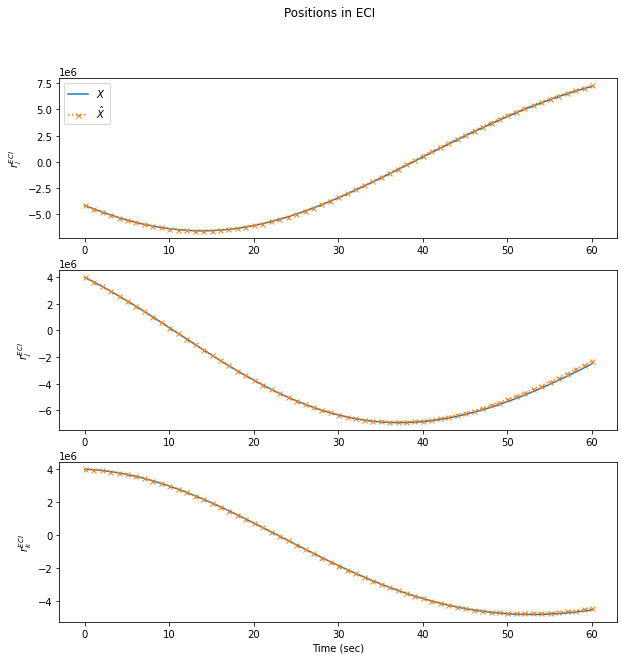

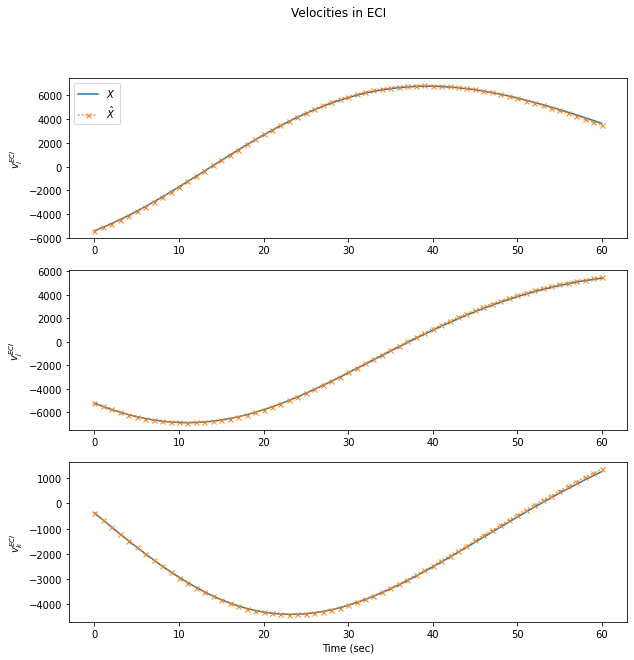

In [11]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Positions in ECI')
axs[0].plot(X_kepler[:,0], label="$X$")
axs[0].plot(mu[:,0], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,1])
axs[1].plot(mu[:,1], ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_kepler[:,2])
axs[2].plot(mu[:,2], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Velocities in ECI')
axs[0].plot(X_kepler[:,3], label="$X$")
axs[0].plot(mu[:,3], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,4])
axs[1].plot(mu[:,4], ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_kepler[:,5])
axs[2].plot(mu[:,5], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

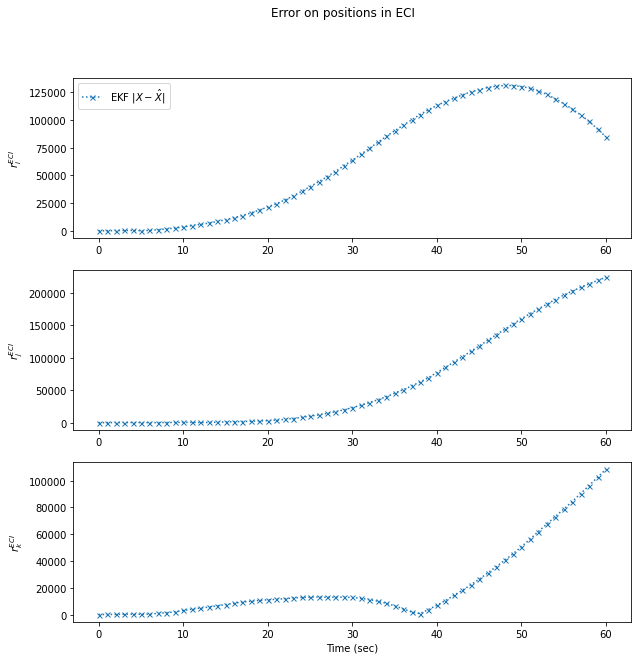

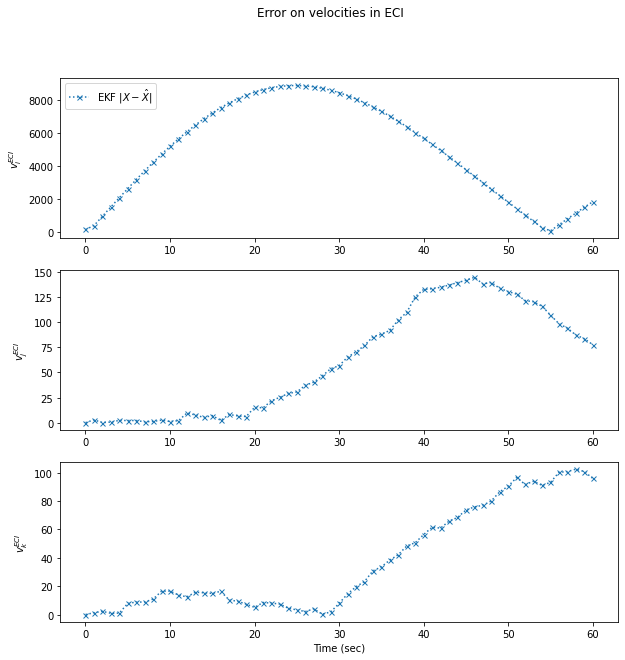

In [12]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI')
axs[0].plot(abs(X_kepler[:,0]-mu[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler[:,1]-mu[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_kepler[:,2]-mu[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI')
axs[0].plot(abs(X_kepler[:,3]-mu[:,4]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler[:,4]-mu[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_kepler[:,5]-mu[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")

In [13]:
from scipy.linalg import sqrtm

def UT(mu, Sigma, lda=2):
    """
    Unscented Transform.
    """
    n = len(mu)
    xtab = np.zeros((2*n+1, n))
    wtab = np.ones((2*n+1, 1))/2/(lda+n)
    xtab[0] = mu
    wtab[0] = lda/(lda+n)
    S = sqrtm((lda+n)*Sigma)
    for i in range(1,n+1):
        xtab[i] = mu + S[:,i-1]
        xtab[i+n] = mu - S[:,i-1]  
    assert np.sum(wtab) == 1
    return xtab, wtab

def UTi(xtab, wtab, lda=2):
    """
    Inverse Unscented Transform.
    """
    mu = np.sum(xtab*wtab, axis=0)
    xh = xtab - mu
    Sigma = np.dot(xh.T, xh*wtab)
    return mu, Sigma

def UKF(X, Y, mu0, Sigma0, Q, R, fDynamics, fMeas, JDynamics, propagator=propagator):
    """
    Unscented Kalman Filter.
    """
    T, n = X_kepler.shape
    m = C_kepler.shape[1]

    mu = np.zeros((T, n))
    Sigma = np.zeros((T, n, n))
    A = np.zeros((T, n, n))
    C = np.zeros((T, m, n))

    mu[0,:] = mu0
    Sigma[0,:,:] = Sigma0
    A[0,:,:] = JDynamics(mu[0,:])
    
    for t in range(1,T):
        #--- Predict ---#
        # Compute sigma-points and weights
        xtab, wtab = UT(mu[t-1,:], Sigma[t-1,:,:])
        for i in range(1,len(xtab)):
            xtab[i] = propagator(xtab[i], dt, fDynamics)
        # Predict mean and covariance
        mu[t,:], Sigma[t,:,:] = UTi(xtab, wtab)
        Sigma[t,:,:] += Q
        
        #--- Update ---#
        # Recompute sigma-points with predictions
        xtab, wtab = UT(mu[t,:], Sigma[t,:,:])
        # Sigma-point measurements
        ytab = np.zeros((2*n+1, m))
        for i in range(1,len(xtab)):
            ytab[i] = fMeas(C[t,:,:], xtab[i])
        wtab = wtab[:,0]
        # Expected measurement
        yh = np.dot(wtab, ytab)
        # Empirical covariances
        Sigma_y = np.dot(wtab*(ytab-yh).T, (ytab-yh))
        Sigma_y += R
        Sigma_xy = np.dot(wtab*(xtab-mu[t,:]).T, (ytab-yh))
        # Update
        K = np.dot(Sigma_xy, np.linalg.inv(Sigma_y))
        mu[t,:] += np.dot(K, (Y[t,:] - yh))
        Sigma[t,:,:] -= np.dot(K, Sigma_xy.T)

    return mu, Sigma

In [14]:
mu, _ = UKF(X=X_kepler, Y=Y_kepler,
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=g,
            JDynamics=keplerianJacobian,
            propagator=propagator
           )

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

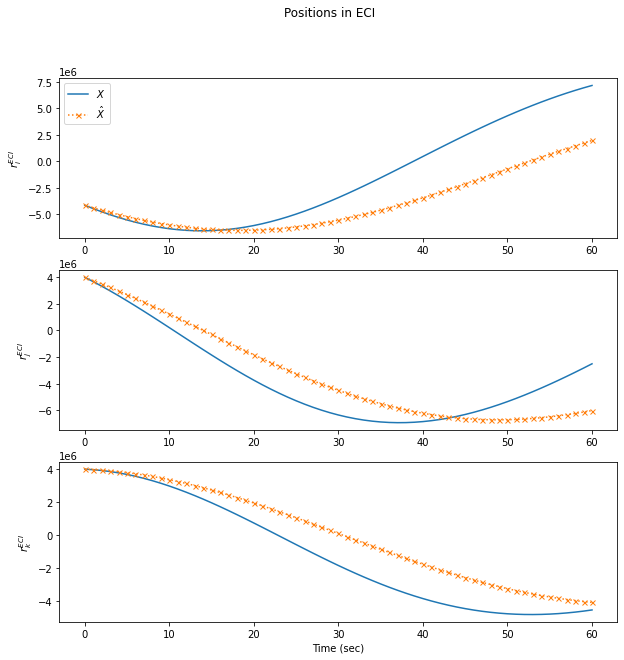

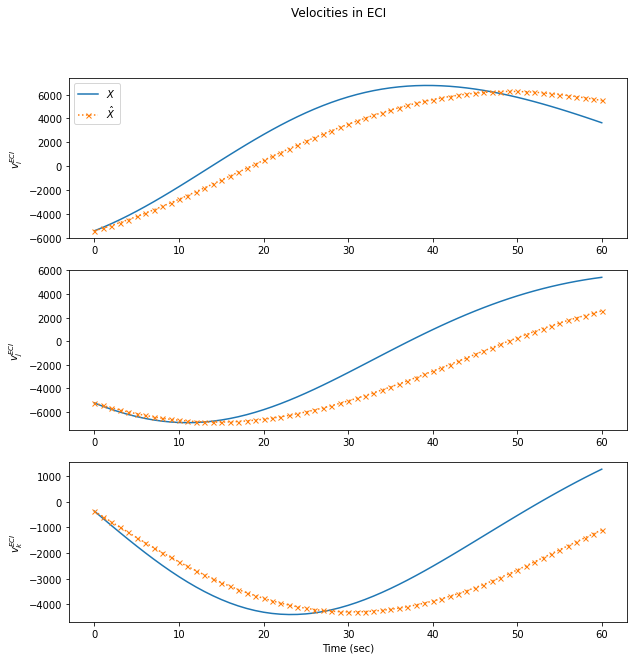

In [15]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Positions in ECI')
axs[0].plot(X_kepler[:,0], label="$X$")
axs[0].plot(mu[:,0], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,1])
axs[1].plot(mu[:,1], ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_kepler[:,2])
axs[2].plot(mu[:,2], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Velocities in ECI')
axs[0].plot(X_kepler[:,3], label="$X$")
axs[0].plot(mu[:,3], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler[:,4])
axs[1].plot(mu[:,4], ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_kepler[:,5])
axs[2].plot(mu[:,5], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

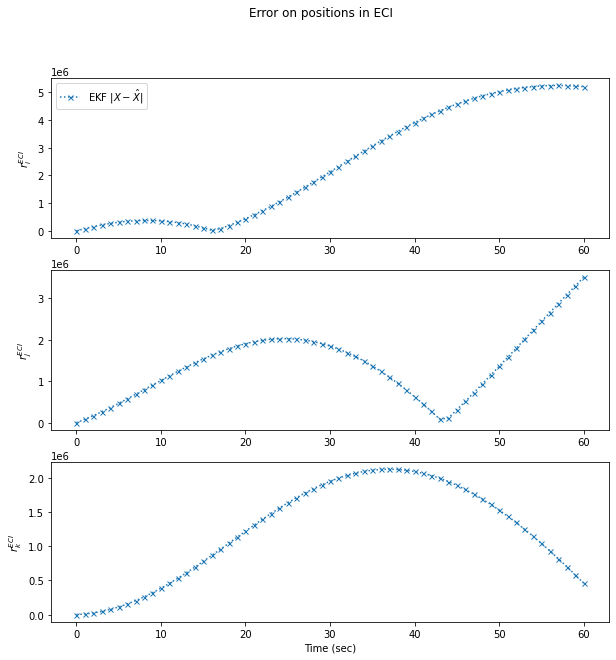

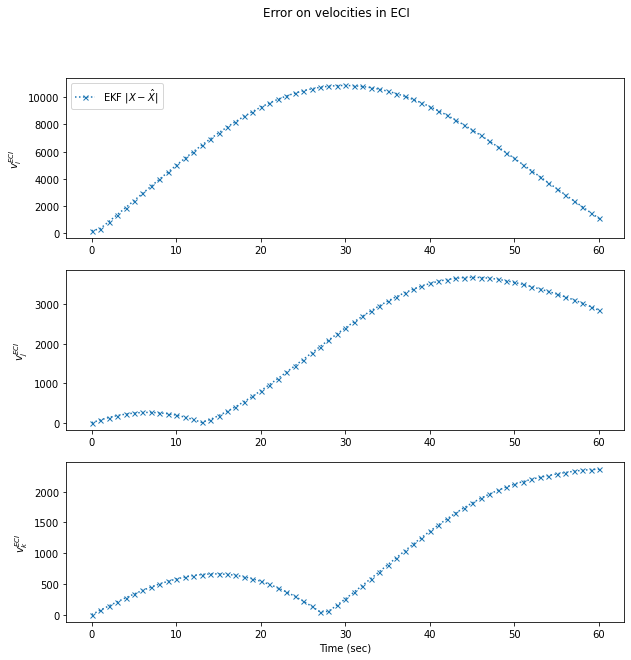

In [16]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on positions in ECI')
axs[0].plot(abs(X_kepler[:,0]-mu[:,0]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler[:,1]-mu[:,1]), ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(abs(X_kepler[:,2]-mu[:,2]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Error on velocities in ECI')
axs[0].plot(abs(X_kepler[:,3]-mu[:,4]), ':x', ms=5, label="EKF $|X-\hat{X}|$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(abs(X_kepler[:,4]-mu[:,4]), ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(abs(X_kepler[:,5]-mu[:,5]), ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")